In [1]:
from __future__ import print_function
import os
import sys
import cv2
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Create data matrix from a list of images
def createDataMatrix(images):
    print("Creating data matrix",end=" ... ")
    sz = images[0].shape # размеры
    data = np.zeros((numImages, sz[0] * sz[1]), dtype=np.float32) # создаем столько же нулевых матриц sz[2]-каналы?
    for i in range(0, numImages): # для каждой картинки
        image = images[i].flatten() #плющим
        data[i,:] = image #записываем в массив матриц
    
    print("DONE")

    return data

In [3]:
# Read images from the directory
def readImages(path):
    print("Reading images from " + path, end="...")
    # Create array of array of images.
    images = []
    # List all files in the directory and read points from text files one by one
    # Список всех файлов в каталоге и чтение точек из текстовых файлов по одному
    for filePath in sorted(os.listdir(path)):  # для каждого файла в папке
        fileExt = os.path.splitext(filePath)[1]
        if fileExt in [".jpg", ".jpeg"]:
         
            # Add to array of images
            imagePath = os.path.join(path, filePath)
            im = cv2.imread(imagePath,0) # читаем картинку
            
            if im is None :
                    print("image:{} not read properly".format(imagePath))
            else :
                    # Convert image to floating point
                    im = np.float32(im)/255.0
                    # Add image to list 
                    images.append(im) # в список его
                    # аугментация перевенутыми картинкаи 
                    # Flip image 
                    # imFlip = cv2.flip(im, 1);
                    # Append flipped image
                    # images.append(imFlip)

    # numImages = len(images) / 2  # т.к. после аугментации изображений стало в 2 раза больше;
    global numImages
    numImages = len(images)
    # Exit if no image found
    if numImages == 0 :
                print("No images found")
                sys.exit(0)

    print(str(numImages) + " файлов прочитано.")
    return images

In [4]:
# Add the weighted eigen faces to the mean face 
# Создаем новую картинку при изменении слайдера
def createNewFace(*args):
    # Start with the mean image
    # вспоминаем чему равна средняя картинка 
    output = averageFace
    
    # Add the eigen faces with the weights
    # Складываем собственные 
    for i in range(0, NUM_EIGEN_FACES):
        '''
        OpenCV does not allow slider values to be negative. 
        So we use weight = sliderValue - MAX_SLIDER_VALUE / 2
        ''' 
        sliderValues[i] = cv2.getTrackbarPos("Weight" + str(i), "Trackbars");
        weight = sliderValues[i] - MAX_SLIDER_VALUE/2
        output = np.add(output, eigenFaces[i] * weight) #скадываем  собсвенное изображение с выходом
        #output = np.add(output, eigenFaces[i] * 1) #скадываем  собсвенное изображение с выходом


    # Display Result at 2x size
    #output = cv2.resize(output, (0,0), fx=2, fy=2)
    cv2.imshow("Result", output)


In [5]:
# Add the weighted eigen faces to the mean face 
# Создаем новую картинку при изменении слайдера
def createNewFace_AndDiff(*args):
    # Start with the mean image
    # вспоминаем чему равна средняя картинка 
    output = averageFace
    
    # Add the eigen faces with the weights
    # Складываем собственные 
    for i in range(0, NUM_EIGEN_FACES):
        '''
        OpenCV does not allow slider values to be negative. 
        So we use weight = sliderValue - MAX_SLIDER_VALUE / 2
        ''' 
        sliderValues[i] = cv2.getTrackbarPos("Weight" + str(i), "Trackbars");
        weight = sliderValues[i] - MAX_SLIDER_VALUE/2
        output = np.add(output, eigenFaces[i] * weight) #скадываем  собсвенное изображение с выходом
        #output = np.add(output, eigenFaces[i] * 1) #скадываем  собсвенное изображение с выходом


    # Display Result at 2x size
    #output = cv2.resize(output, (0,0), fx=2, fy=2)
    
    output = abs(defect_img-output)
    cv2.imshow("Result", output)


In [6]:
def resetSliderValues(*args):
    for i in range(0, NUM_EIGEN_FACES):
        cv2.setTrackbarPos("Weight" + str(i), "Trackbars", MAX_SLIDER_VALUE/2);    
    createNewFace()

In [7]:
# Number of EigenFaces
NUM_EIGEN_FACES = 10

# Maximum weight
MAX_SLIDER_VALUE = 255

# Directory containing images
dirName = "frames2/leaf2"

# Read images
images = readImages(dirName)

Reading images from frames2/leaf2...50 файлов прочитано.


In [8]:
# Size of images
sz = images[0].shape

# Create data matrix for PCA.
data = createDataMatrix(images)

Creating data matrix ... DONE


In [9]:
# Compute the eigenvectors from the stack of images created
print("Calculating PCA ", end="...")
# мы получаем сразу и среднее и собственные вектора
mean, eigenVectors = cv2.PCACompute(data, mean=None, maxComponents=NUM_EIGEN_FACES)
print ("DONE")

# прекраиваем среднее изображение из плоского массива в картинку
averageFace = mean.reshape(sz)
meanFace  = mean

eigenFaces = []; 

for eigenVector in eigenVectors: # для каждого собственного вектора
    eigenFace = eigenVector.reshape(sz) # разворачиваем в картинку
    eigenFaces.append(eigenFace) # добавляем в список


Calculating PCA ...DONE


In [10]:
"""
# Create window for displaying Mean Face
cv2.namedWindow("Result", cv2.WINDOW_NORMAL)

# Display result at 2x size
output = cv2.resize(averageFace, (0,0), fx=2, fy=2)
cv2.imshow("Result", output)

# Create Window for trackbars
cv2.namedWindow("Trackbars", cv2.WINDOW_NORMAL)

sliderValues = []

# Create Trackbars
for i in range(0, NUM_EIGEN_FACES):
    sliderValues.append(MAX_SLIDER_VALUE/2)
    # cv.CreateTrackbar(trackbarName, windowName, value, count, onChange) 
    cv2.createTrackbar( "Weight" + str(i), "Trackbars", int(MAX_SLIDER_VALUE/2), MAX_SLIDER_VALUE, createNewFace)

# You can reset the sliders by clicking on the mean image.
cv2.setMouseCallback("Result", resetSliderValues);

print('''Usage:
Change the weights using the sliders
Click on the result window to reset sliders
Hit ESC to terminate program.''')

cv2.waitKey(0)
cv2.destroyAllWindows()
"""

'\n# Create window for displaying Mean Face\ncv2.namedWindow("Result", cv2.WINDOW_NORMAL)\n\n# Display result at 2x size\noutput = cv2.resize(averageFace, (0,0), fx=2, fy=2)\ncv2.imshow("Result", output)\n\n# Create Window for trackbars\ncv2.namedWindow("Trackbars", cv2.WINDOW_NORMAL)\n\nsliderValues = []\n\n# Create Trackbars\nfor i in range(0, NUM_EIGEN_FACES):\n    sliderValues.append(MAX_SLIDER_VALUE/2)\n    # cv.CreateTrackbar(trackbarName, windowName, value, count, onChange) \n    cv2.createTrackbar( "Weight" + str(i), "Trackbars", int(MAX_SLIDER_VALUE/2), MAX_SLIDER_VALUE, createNewFace)\n\n# You can reset the sliders by clicking on the mean image.\ncv2.setMouseCallback("Result", resetSliderValues);\n\nprint(\'\'\'Usage:\nChange the weights using the sliders\nClick on the result window to reset sliders\nHit ESC to terminate program.\'\'\')\n\ncv2.waitKey(0)\ncv2.destroyAllWindows()\n'

In [11]:
im = cv2.imread("Defect.jpg",0) # читаем картинку
        
if im is None :
    print("image:{} not read properly".format(imagePath))
else :
    # Convert image to floating point
    im = np.float32(im)/255.0
    print("Creating data matrix",end=" ... ")
    sz = im.shape # размеры
    print(im.shape)
    defect_data = np.zeros((sz[0] * sz[1]), dtype=np.float32) # создаем столько же нулевых матриц sz[2]-каналы?
    image = im.flatten() #плющим
    defect_data = image #записываем в массив матриц

Creating data matrix ... (1080, 1920)


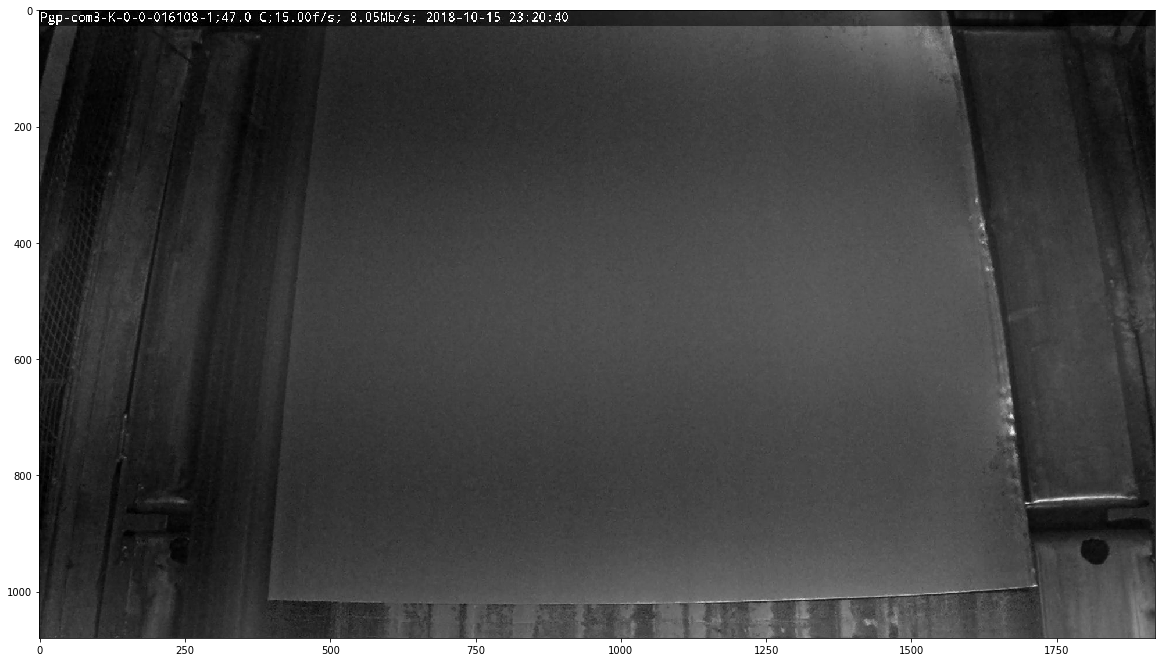

In [12]:
defect_img = defect_data.reshape(sz)

plt.figure(figsize = (20,20))
# показать среднее изображение
plt.imshow(defect_img,cmap='gray')

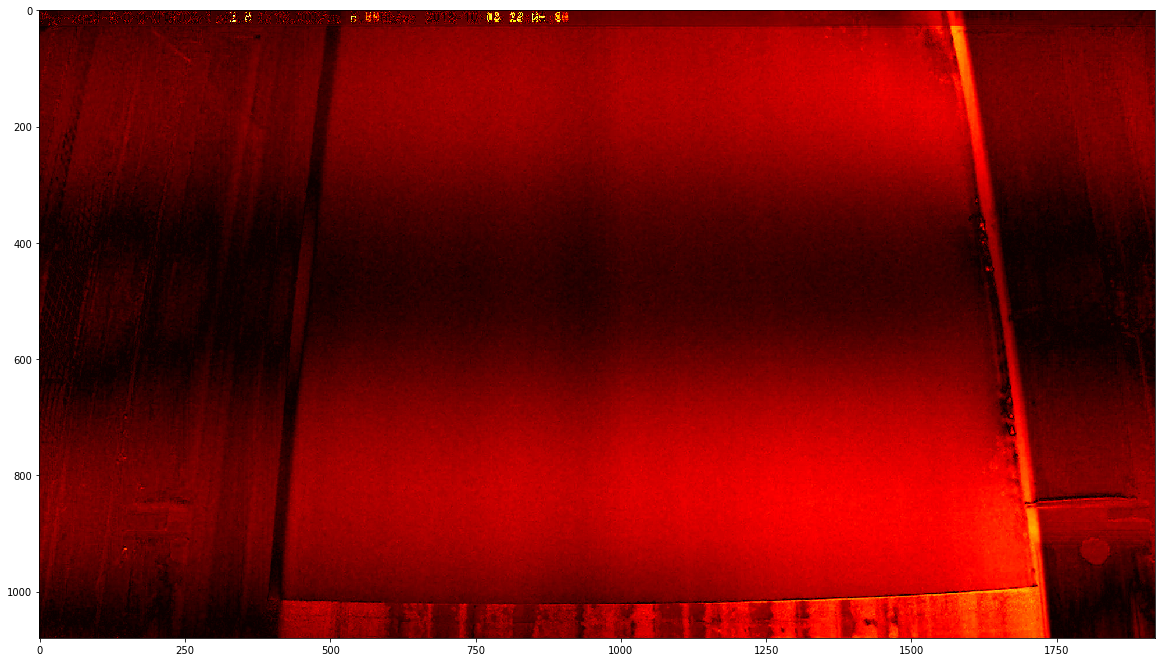

In [13]:
difference_data=abs(meanFace-defect_data)
difference_img = difference_data.reshape(sz)

plt.figure(figsize = (20,20))
# показать среднее изображение
plt.imshow(difference_img,cmap='hot')

In [ ]:
# Create window for displaying Mean Face
cv2.namedWindow("Result", cv2.WINDOW_NORMAL)

# Display result at 2x size
# output = cv2.resize(averageFace, (0,0), fx=2, fy=2)
output = abs(defect_img-averageFace)

cv2.imshow("Result", output)

# Create Window for trackbars
cv2.namedWindow("Trackbars", cv2.WINDOW_NORMAL)

sliderValues = []

# Create Trackbars
for i in range(0, NUM_EIGEN_FACES):
    sliderValues.append(MAX_SLIDER_VALUE/2)
    # cv.CreateTrackbar(trackbarName, windowName, value, count, onChange) 
    cv2.createTrackbar( "Weight" + str(i), "Trackbars", int(MAX_SLIDER_VALUE/2), MAX_SLIDER_VALUE, createNewFace_AndDiff)

# You can reset the sliders by clicking on the mean image.
cv2.setMouseCallback("Result", resetSliderValues);

print('''Usage:
Change the weights using the sliders
Click on the result window to reset sliders
Hit ESC to terminate program.''')

cv2.waitKey(0)
cv2.destroyAllWindows()

Usage:
Change the weights using the sliders
Click on the result window to reset sliders
Hit ESC to terminate program.


TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

TypeError: integer argument expected, got float

In [14]:
print(defect_img*255)
print(averageFace*255)


[[  0.  12.   0. ...   6.   6.   5.]
 [ 12.   0.   0. ...   7.   6.   5.]
 [  0.  14.   3. ...   7.   6.   6.]
 ...
 [ 44.  45.  46. ... 103. 101. 101.]
 [ 43.  44.  46. ... 105. 103. 103.]
 [ 42.  43.  45. ... 106. 105. 105.]]
[[ 7.660001 16.760002 38.039997 ... 30.099998 30.259998 30.339998]
 [26.559996 29.600008 39.88001  ... 30.140001 30.259998 30.339998]
 [31.599995 28.700003 19.220009 ... 30.220001 30.339998 30.400002]
 ...
 [41.999992 42.379997 42.759995 ... 94.72     94.76     94.8     ]
 [42.079994 42.439995 42.839993 ... 94.7      94.740005 94.78    ]
 [42.079994 42.45999  42.839993 ... 94.68001  94.72     94.78    ]]
